<a href="https://colab.research.google.com/github/seschm/Internship-Gaertner/blob/main/Reproduction_Paper_with_non_separable_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, pmap, grad
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import torch.utils.data as data

from tqdm.auto import tqdm
import random as rng

import numpy as np
from numpy import sqrt, cos, sin, exp, pi, log2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.stats import norm

In [29]:
def generate_random_pure_state(nQubit):
    """
    Generates Haar random pure state.
    To generate a random pure state, take any basis state, e.g. |00...00>
    and apply a random unitary matrix. For consistency each basis state should be the same. 
    """
    baseRho=np.zeros((2**nQubit,2**nQubit),dtype=complex)
    baseRho[0,0]=1
    U=unitary_group.rvs(2**nQubit)
    return U@baseRho@U.conj().T

In [30]:
def generate_single_qubit(theta,phi):
    """
    Generates single qubit out of the given angles theta and phi.
    First construct the single qubit state as an array of shape (2, 1).
    Then compute the matrixproduct with its adjoint state.
    """
    state = np.array([[cos(theta/2)],[sin(theta/2)*exp(phi*1.j)]])
    return state@state.conj().T

In [31]:
def generate_random_seperable_pure_state(nQubit):
    """
    Generates random seperable pure state.
    First generate the desired number of random pure states.
    Then tensor them together.
    """
    single_qubits = []
    for i in range(0,nQubit):
        single_qubits.append(generate_random_pure_state(1))
    tensored_qubits = [single_qubits[0]]
    for i in range(1,nQubit):
        tensored_qubits.append(np.kron(tensored_qubits[-1],single_qubits[i]))    
    return tensored_qubits[-1]

In [32]:
def depolarizing_channel(state,p):
    """
    Applies a depolarizing channel to the given state with p the probability of the completely mixed state.
    """
    d=len(state[0])
    return p*np.eye(d)/d+(1-p)*state

In [33]:
def generate_POVM(theta,phi,nQubit):
    """
    Generates a POVM consisting of multi qubit projectors on to the axis defined by the two angles theta and phi.
    First generates all possible states (combinations of spin up and down) as strings containing 1s and 0s.
    The order is equal to binary counting.
    Then generates the single qubit projector and its orthogonal projector.
    In the next step all single qubit projectors corresponding to the same state are gathered in the correct order and then tensored together to get an element of the POVM.
    Returns the POVM with the elements beeing ordered equal to binary counting (-> up ... up, up ... up down, up ... up down up, ...).
    """
    up_and_downs = []

    for i in range(2**nQubit):
        binary = bin(i)[2:]
        zeros = np.zeros(nQubit-len(binary), dtype=int)
        for k in range(nQubit-len(binary)):
            binary = '0' + binary
        up_and_downs.append(binary)

    projector=generate_single_qubit(theta,phi)
    orthogonal_projector = np.eye(2)-projector
    POVM = []

    for i in range(2**nQubit):
        tensored_projector = []
        single_projectors = []
        for j in range(nQubit):
            if up_and_downs[i][j] == '0':
                single_projectors.append(projector)
            if up_and_downs[i][j] == '1':
                single_projectors.append(orthogonal_projector)
        tensored_projector.append(single_projectors[0])
        for k in range(nQubit-1):
            tensored_projector.append(np.kron(tensored_projector[-1],single_projectors[k+1]))
        POVM.append(tensored_projector[-1])
    
    return POVM

In [34]:
def perform_multi_qubit_measurement(state,POVM):
    """
    Performs a multi qubit measurement with the given POVM.
    """
    probabilities = []
    for element in POVM:
        probabilities.append(np.trace(element@state))
    return probabilities

In [35]:
def perform_noisy_multi_qubit_measurement(state,POVM,p):
    """
    Generates probabilities of the noisy state.
    First applies the noise, then generates the probabilities.
    """
    noisy_state = depolarizing_channel(state,p)
    return perform_multi_qubit_measurement(noisy_state,POVM)

In [36]:
def sampling(probabilities,samplesize=1000):
    """
    Takes in a probability distribution and samples from it.
    """
    sampling = rng.choices(np.arange(0,len(probabilities)), weights=probabilities, k=samplesize)
    sampled_probabilities = []
    for element in np.arange(0,len(probabilities)):
        sampled_probabilities.append(sampling.count(element)/samplesize)
    return sampled_probabilities

In [37]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [38]:
def loss_fn(state, params, batch_input, batch_target_output):
    predictions = state.apply_fn(params, batch_input)
    #loss = jnp.mean(optax.softmax_cross_entropy(predictions,batch_target_output))
    loss = jnp.mean(-jnp.sum(batch_target_output*jax.lax.log(predictions),axis=1))
    return loss

In [39]:
@jax.jit
def accuracy_MSE(acc_input, acc_target_output,nQubit):
  acc = jnp.mean(jnp.sum(jnp.abs(acc_input-acc_target_output)**2,axis=2)/(2**nQubit))
  return acc

In [40]:
@jax.jit
def accuracy_KLD(acc_input, acc_target_output):
  acc = jnp.mean(jnp.sum(acc_target_output*jnp.log(acc_target_output/acc_input),axis=2))
  return acc

In [41]:
@jax.jit
def accuracy_IF(acc_input, acc_target_output):
  acc = jnp.mean(1-(jnp.sum(jnp.sqrt(acc_target_output*acc_input),axis=2))**2)
  return acc

In [42]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch_input, batch_target_output):
    # Gradient function
    grad_fn = jax.value_and_grad(loss_fn,# Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch_input, batch_target_output)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [43]:
def train_model(state, batched_training_input, batched_training_target_outputs, acc_input, acc_target_output,nQubit, num_epochs = 100):
  
  acc_test_MSE = []
  acc_training_MSE = []
  acc_unmitigated_test_MSE = []

  acc_test_KLD = []
  acc_training_KLD = []
  acc_unmitigated_test_KLD = []

  acc_test_IF = []
  acc_training_IF = []
  acc_unmitigated_test_IF = []

  for epoch in tqdm(range(num_epochs)):
    for i in range(len(batched_training_input)):
      state, loss = train_step(state, batched_training_input[i], batched_training_target_outputs[i])

    predictions_test = state.apply_fn(state.params, acc_input)
    predictions_training = state.apply_fn(state.params, batched_training_input)

    acc_test_MSE.append(accuracy_MSE(predictions_test, acc_target_output,nQubit))
    acc_training_MSE.append(accuracy_MSE(predictions_training, batched_training_target_outputs,nQubit))
    acc_unmitigated_test_MSE.append(accuracy_MSE(acc_input, acc_target_output,nQubit))

    acc_test_KLD.append(accuracy_KLD(predictions_test, acc_target_output))
    acc_training_KLD.append(accuracy_KLD(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_KLD.append(accuracy_KLD(acc_input, acc_target_output))

    acc_test_IF.append(accuracy_IF(predictions_test, acc_target_output))
    acc_training_IF.append(accuracy_IF(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_IF.append(accuracy_IF(acc_input, acc_target_output))

  return state, [acc_test_MSE, acc_training_MSE, acc_unmitigated_test_MSE], [acc_test_KLD, acc_training_KLD, acc_unmitigated_test_KLD], [acc_test_IF, acc_training_IF, acc_unmitigated_test_IF]

In [44]:
class MLP(nn.Module):

  num_neurons_per_layer : list[int]   # List containing the number of neurons per layer (except input layer)


  @nn.compact
  def __call__(self, x):
    activation = x
    for i, numb_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(numb_neurons)(activation) # tell how to initialize weigths -> reduce variance
      if i != len(self.num_neurons_per_layer) - 1:
        activation = nn.relu(activation)
    return jax.nn.softmax(activation)

  0%|          | 0/1800 [00:00<?, ?it/s]

<ipython-input-45-faa4416a6d29>:33: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j] = noisy_probs[j]
<ipython-input-45-faa4416a6d29>:34: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/400 [00:00<?, ?it/s]

<ipython-input-45-faa4416a6d29>:43: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j] = noisy_probs[j]
<ipython-input-45-faa4416a6d29>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

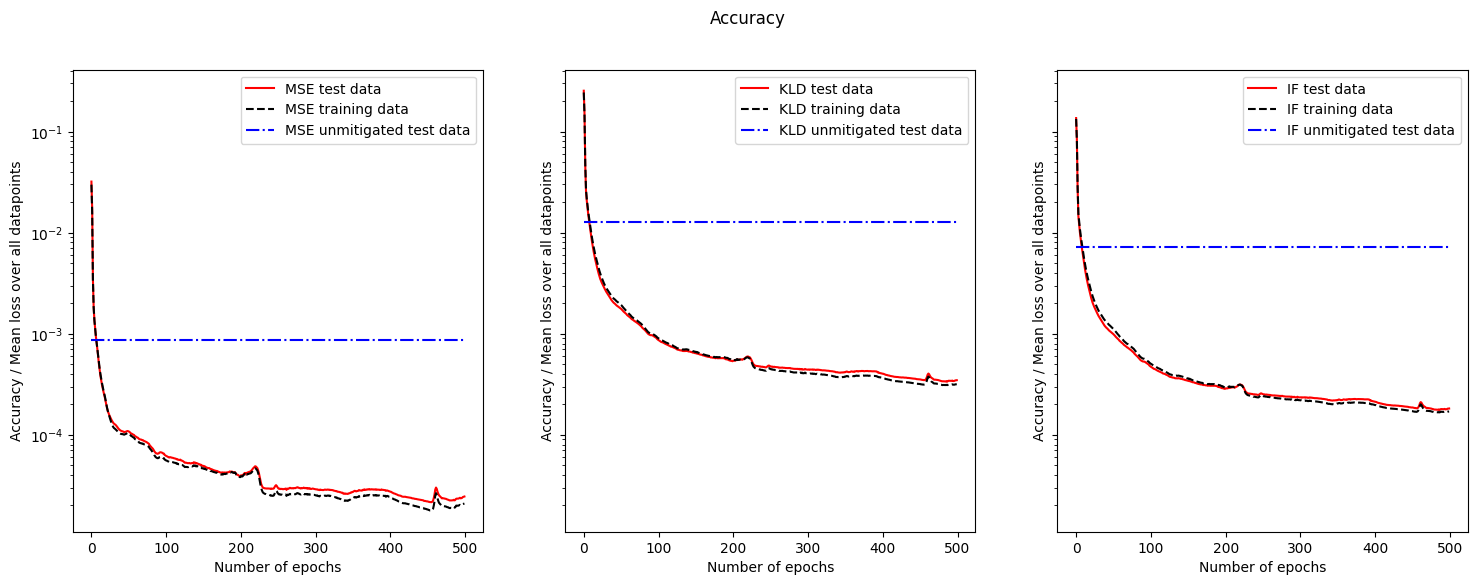

In [45]:
nQubit = 2
layers = [20,20,20,20,20,2**nQubit]
num_epochs = 500
batch_size = 50
learning_rate = 0.001
training_states = 1800
test_states = 400
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

for i in tqdm(range(training_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #training_data[i][j] = noisy_probs_sampled[j]
        training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #test_data[i][j] = noisy_probs_sampled[j]
        test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []  
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []  
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

trained_model_state2, MSE_data2, KLD_data2, IF_data2 = train_model(model_state, batched_tr_inp, batched_tr_tar_out, 
                                                               batched_test_inp, batched_test_tar_out, 
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data2[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data2[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data2[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data2[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data2[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data2[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data2[0],label="IF test data",color="red")
axs[2].plot(i,IF_data2[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data2[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

  0%|          | 0/3800 [00:00<?, ?it/s]

<ipython-input-46-353a054290e1>:34: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j] = noisy_probs[j]
<ipython-input-46-353a054290e1>:35: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/600 [00:00<?, ?it/s]

<ipython-input-46-353a054290e1>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j] = noisy_probs[j]
<ipython-input-46-353a054290e1>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

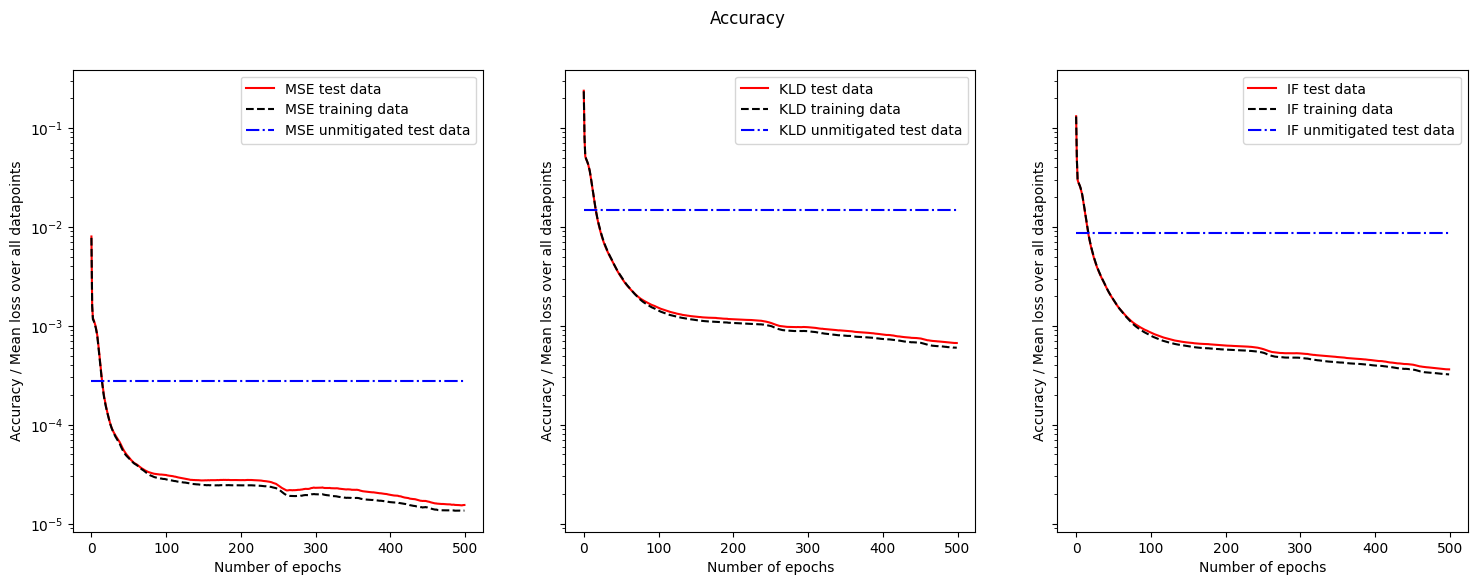

In [46]:
nQubit = 3
layers = [40,40,2**nQubit]
scale = 1 # scale the variance of the initial params
num_epochs = 500
batch_size = 50
learning_rate = 0.001
training_states = 3800
test_states = 600
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = scale*random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

for i in tqdm(range(training_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #training_data[i][j] = noisy_probs_sampled[j]
        training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #test_data[i][j] = noisy_probs_sampled[j]
        test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []  
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []  
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

trained_model_state3, MSE_data3, KLD_data3, IF_data3 = train_model(model_state, batched_tr_inp, batched_tr_tar_out, 
                                                               batched_test_inp, batched_test_tar_out, 
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data3[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data3[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data3[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data3[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data3[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data3[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data3[0],label="IF test data",color="red")
axs[2].plot(i,IF_data3[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data3[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

  0%|          | 0/7800 [00:00<?, ?it/s]

<ipython-input-47-062f0b12d7b8>:34: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j] = noisy_probs[j]
<ipython-input-47-062f0b12d7b8>:35: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/800 [00:00<?, ?it/s]

<ipython-input-47-062f0b12d7b8>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j] = noisy_probs[j]
<ipython-input-47-062f0b12d7b8>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

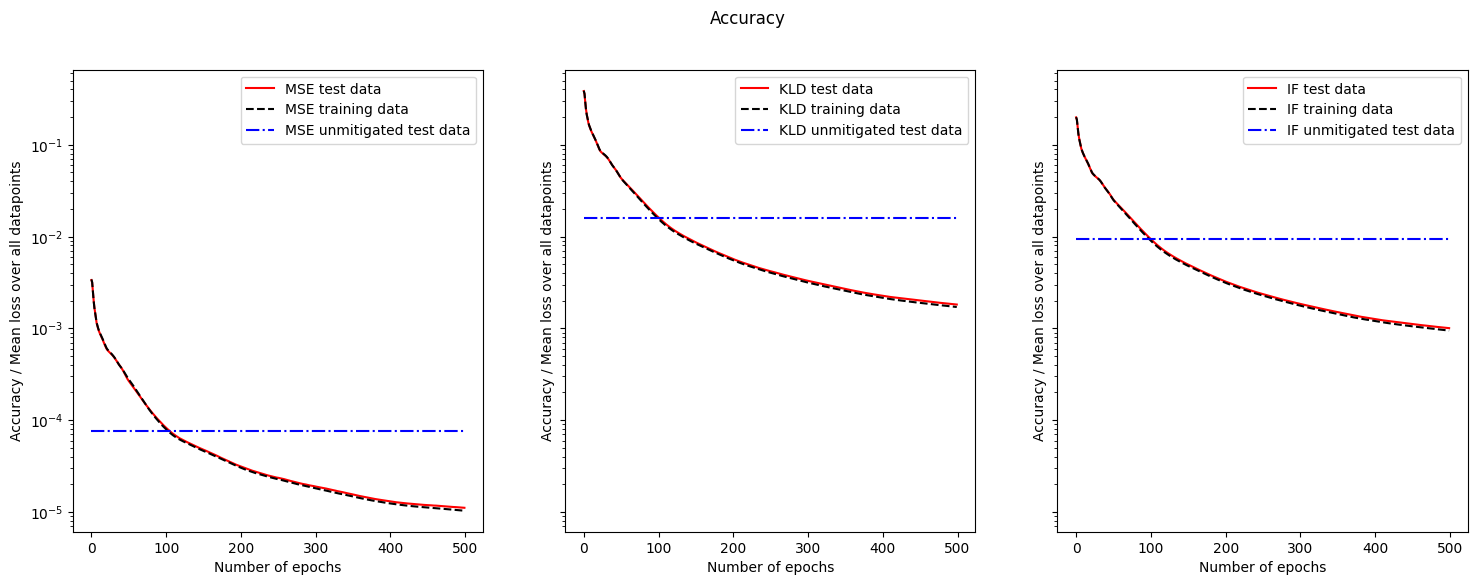

In [47]:
nQubit = 4
layers = [80,80,80,80,80,80,80,2**nQubit]
scale = 1 # scale the variance of the initial params
num_epochs = 500
batch_size = 50
learning_rate = 5*10**-5
training_states = 7800
test_states = 800
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = scale*random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

for i in tqdm(range(training_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #training_data[i][j] = noisy_probs_sampled[j]
        training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #test_data[i][j] = noisy_probs_sampled[j]
        test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []  
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []  
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

trained_model_state4, MSE_data4, KLD_data4, IF_data4 = train_model(model_state, batched_tr_inp, batched_tr_tar_out, 
                                                               batched_test_inp, batched_test_tar_out, 
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data4[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data4[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data4[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data4[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data4[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data4[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data4[0],label="IF test data",color="red")
axs[2].plot(i,IF_data4[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data4[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

  0%|          | 0/9850 [00:00<?, ?it/s]

<ipython-input-48-5a9ba0c740b4>:34: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j] = noisy_probs[j]
<ipython-input-48-5a9ba0c740b4>:35: ComplexWarning: Casting complex values to real discards the imaginary part
  training_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-48-5a9ba0c740b4>:44: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j] = noisy_probs[j]
<ipython-input-48-5a9ba0c740b4>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  test_data[i][j+2**nQubit] = probs[j]


  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Accuracy')

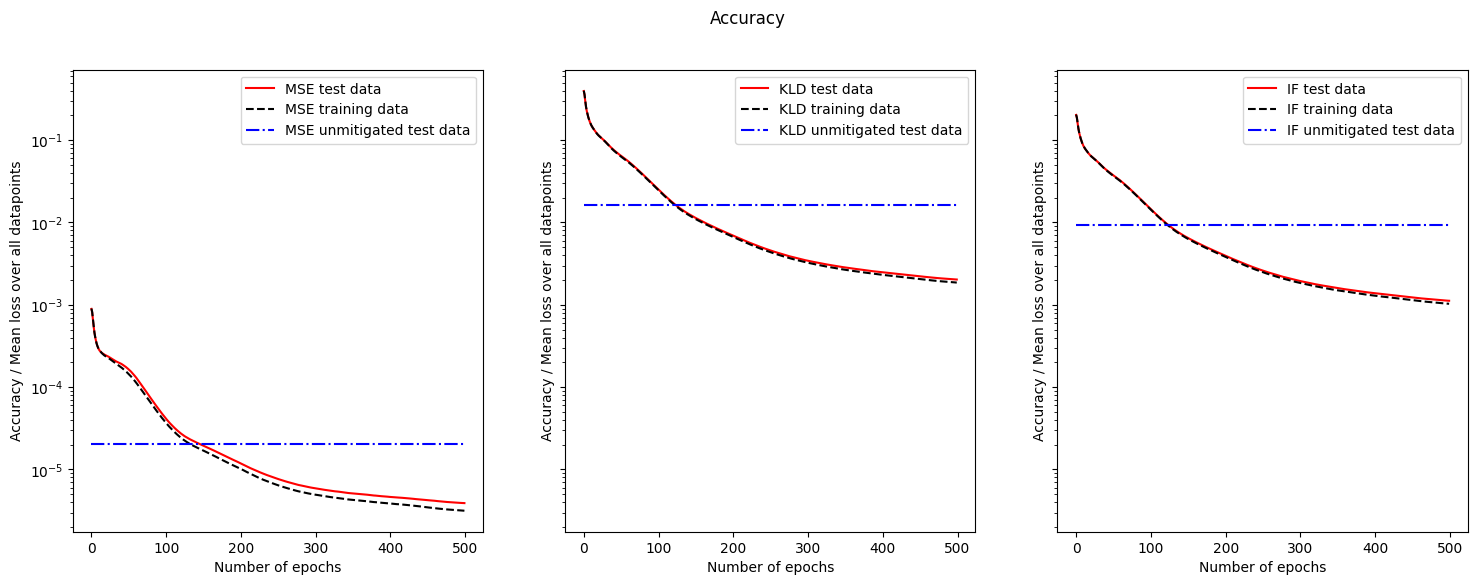

In [48]:
nQubit = 5
layers = [160,160,160,160,160,2**nQubit]
scale = 1 # scale the variance of the initial params
num_epochs = 500
batch_size = 50
learning_rate = 5*10**-5
training_states = 9850
test_states = 1000
training_data = np.zeros((training_states,2**nQubit*2))
test_data = np.zeros((test_states,2**nQubit*2))
theta = 0
phi = 0
p = 0.15

model = MLP(num_neurons_per_layer=layers)        # Initialize network
x_key, init_key = random.split(random.PRNGKey(0))
x = scale*random.normal(x_key, (batch_size, 2**nQubit))                    # Batch size 100, input size 2
params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)

optimizer = optax.adam(learning_rate=learning_rate) #sgd
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

POVM = generate_POVM(theta,phi,nQubit)

for i in tqdm(range(training_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #training_data[i][j] = noisy_probs_sampled[j]
        training_data[i][j] = noisy_probs[j]
        training_data[i][j+2**nQubit] = probs[j]

for i in tqdm(range(test_states)):
    state = generate_random_pure_state(nQubit)
    probs = perform_multi_qubit_measurement(state,POVM)
    noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
    #noisy_probs_sampled = sampling(noisy_probs)
    for j in range(2**nQubit):
        #test_data[i][j] = noisy_probs_sampled[j]
        test_data[i][j] = noisy_probs[j]
        test_data[i][j+2**nQubit] = probs[j]

data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_training_input = []  
batched_training_target_outputs = []

for batch in data_loader_training:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_training_input.append(inputs)
  batched_training_target_outputs.append(targets)


data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
batched_test_input = []  
batched_test_target_outputs = []

for batch in data_loader_test:
  inputs, targets = jnp.split(batch,2,axis=1)
  batched_test_input.append(inputs)
  batched_test_target_outputs.append(targets)

batched_tr_inp = jnp.asarray(batched_training_input)
batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
batched_test_inp = jnp.asarray(batched_test_input)
batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

trained_model_state5, MSE_data5, KLD_data5, IF_data5 = train_model(model_state, batched_tr_inp, batched_tr_tar_out, 
                                                               batched_test_inp, batched_test_tar_out, 
                                                               nQubit=nQubit, num_epochs = num_epochs)

i = np.arange(0,num_epochs)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axs[0].plot(i,MSE_data5[0],label="MSE test data",color="red")
axs[0].plot(i,MSE_data5[1],label="MSE training data",linestyle="--",color="black")
axs[0].plot(i,MSE_data5[2],label="MSE unmitigated test data",linestyle="-.",color="blue")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].plot(i,KLD_data5[0],label="KLD test data",color="red")
axs[1].plot(i,KLD_data5[1],label="KLD training data",linestyle="--",color="black")
axs[1].plot(i,KLD_data5[2],label="KLD unmitigated test data",linestyle="-.",color="blue")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[1].set_yscale('log')
axs[1].legend()
axs[2].plot(i,IF_data5[0],label="IF test data",color="red")
axs[2].plot(i,IF_data5[1],label="IF training data",linestyle="--",color="black")
axs[2].plot(i,IF_data5[2],label="IF unmitigated test data",linestyle="-.",color="blue")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
axs[2].set_yscale('log')
axs[2].legend()
fig.suptitle('Accuracy')

Text(0.5, 0.98, 'NN improvement')

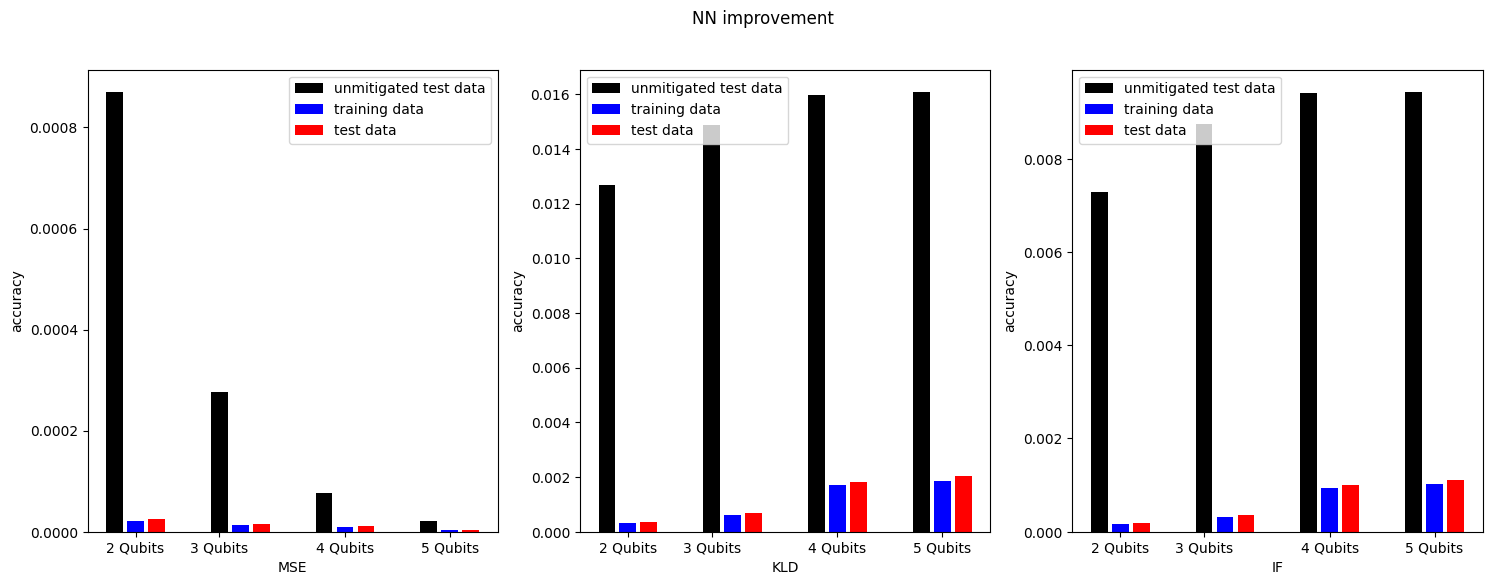

In [49]:
labels = ["2 Qubits","3 Qubits","4 Qubits","5 Qubits"]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

axs[0].bar(0,MSE_data2[2][-1],label="unmitigated test data",color="black")
axs[0].bar(1,MSE_data2[1][-1],label="training data",color="blue")
axs[0].bar(2,MSE_data2[0][-1],label="test data",color="red")
axs[0].bar(5,MSE_data3[2][-1],color="black")
axs[0].bar(6,MSE_data3[1][-1],color="blue")
axs[0].bar(7,MSE_data3[0][-1],color="red")
axs[0].bar(10,MSE_data4[2][-1],color="black")
axs[0].bar(11,MSE_data4[1][-1],color="blue")
axs[0].bar(12,MSE_data4[0][-1],color="red")
axs[0].bar(15,MSE_data5[2][-1],color="black")
axs[0].bar(16,MSE_data5[1][-1],color="blue")
axs[0].bar(17,MSE_data5[0][-1],color="red")
axs[0].set_xticks([1,5,11,16])
axs[0].set_xticklabels(labels)
axs[0].set_xlabel("MSE")
axs[0].set_ylabel("accuracy")
axs[0].legend()

axs[1].bar(0,KLD_data2[2][-1],label="unmitigated test data",color="black")
axs[1].bar(1,KLD_data2[1][-1],label="training data",color="blue")
axs[1].bar(2,KLD_data2[0][-1],label="test data",color="red")
axs[1].bar(5,KLD_data3[2][-1],color="black")
axs[1].bar(6,KLD_data3[1][-1],color="blue")
axs[1].bar(7,KLD_data3[0][-1],color="red")
axs[1].bar(10,KLD_data4[2][-1],color="black")
axs[1].bar(11,KLD_data4[1][-1],color="blue")
axs[1].bar(12,KLD_data4[0][-1],color="red")
axs[1].bar(15,KLD_data5[2][-1],color="black")
axs[1].bar(16,KLD_data5[1][-1],color="blue")
axs[1].bar(17,KLD_data5[0][-1],color="red")
axs[1].set_xticks([1,5,11,16])
axs[1].set_xticklabels(labels)
axs[1].set_xlabel("KLD")
axs[1].set_ylabel("accuracy")
axs[1].legend()

axs[2].bar(0,IF_data2[2][-1],label="unmitigated test data",color="black")
axs[2].bar(1,IF_data2[1][-1],label="training data",color="blue")
axs[2].bar(2,IF_data2[0][-1],label="test data",color="red")
axs[2].bar(5,IF_data3[2][-1],color="black")
axs[2].bar(6,IF_data3[1][-1],color="blue")
axs[2].bar(7,IF_data3[0][-1],color="red")
axs[2].bar(10,IF_data4[2][-1],color="black")
axs[2].bar(11,IF_data4[1][-1],color="blue")
axs[2].bar(12,IF_data4[0][-1],color="red")
axs[2].bar(15,IF_data5[2][-1],color="black")
axs[2].bar(16,IF_data5[1][-1],color="blue")
axs[2].bar(17,IF_data5[0][-1],color="red")
axs[2].set_xticks([1,5,11,16])
axs[2].set_xticklabels(labels)
axs[2].set_xlabel("IF")
axs[2].set_ylabel("accuracy")
axs[2].legend()

fig.suptitle('NN improvement')